In [1]:
from headers import *
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
from utils.custom_train_test_split import *
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, make_scorer, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from joblib import dump, load
from IPython.display import Markdown, display
from math import sqrt
import json

In [2]:
cutoffs = [0.0, 0.01, 0.02, 0.03, 0.05, 0.07, 0.10, 0.15, 0.20, 0.25, 0.35]

trainDf, testDf = per_year_train_test_split(['../data/combined_inner_ticker.csv', '../data/extra-data/combined_inner_ticker.csv'])
X_train = trainDf[ratioKeys + relativeRatioKeys]
X_test = testDf[ratioKeys + relativeRatioKeys]

resultsToPlot = {}

for yLabel in yAlpha:
    if yLabel not in resultsToPlot:
        resultsToPlot[yLabel] = {}
    for cutoff in cutoffs:
        y_train = np.where(trainDf[yLabel] <= cutoff, 0, 1)
        y_test = np.where(testDf[yLabel] <= cutoff, 0, 1)
        pipelines = {
            'tree': Pipeline([
                ('scaler', StandardScaler()),
                ('tree', DecisionTreeClassifier())
            ]),
            'svc': Pipeline([
                ('scaler', StandardScaler()),
                ('svc', LinearSVC())
            ])
        }
        params = [
            {
                'tree__criterion': ["gini", "entropy", "log_loss"],
            },
            {
                'svc__C': [0.1, 0.5, 1.0, 5.0, 10.0],
                'svc__penalty': ['l1', 'l2']
            }
        ]
        for (key, pipeline), param_grid in zip(pipelines.items(), params):
            grid = GridSearchCV(pipeline,
                        param_grid,
                        cv=StratifiedKFold(3, shuffle=True, random_state=3),
                        verbose=1,
                        refit=True,
                        n_jobs=-1,
                        # scoring='f1',
                        )
            grid.fit(X_train, y_train)
            y_pred = grid.predict(X_test)
            wholeTestData = testDf.loc[testDf.index.intersection(X_test.index)]
            
            xTaken = X_test[y_pred == 1]
            xTrue = X_test[y_test == 1]
            
            takenData = testDf.loc[testDf.index.intersection(xTaken.index)]
            trueData = testDf.loc[testDf.index.intersection(xTrue.index)]
            
            prc = round(takenData.loc[:, yLabel].count() / wholeTestData.loc[:, yLabel].count(), 4) * 100
            print(f'MODEL {key}')
            print(f'For {yLabel}, yCutoff = {cutoff}, taken used - {takenData.loc[:, yLabel].count()} is {prc}%')
            print(f'Mean was {round(takenData.loc[:, yLabel].mean() * 100, 2)}%, median was {round(takenData.loc[:, yLabel].median()*100, 2)}%')
            print(f'% of True in dataset {round(len(y_test[y_test==1]) / len(y_test) * 100, 2)}% resulted in {round(trueData.loc[:, yLabel].mean() * 100, 2)}% and median {round(trueData.loc[:, yLabel].median() * 100,2)}%')
            print('-----------')
            
            if key not in resultsToPlot[yLabel]:
                resultsToPlot[yLabel][key] = []
            resultsToPlot[yLabel][key].append({
                'mean': takenData.loc[:, yLabel].mean(),
                'median': takenData.loc[:, yLabel].median(),
                'taken': takenData.loc[:, yLabel].count()
            })

Fitting 3 folds for each of 3 candidates, totalling 9 fits
MODEL tree
For alpha1Year, yCutoff = 0.0, taken used - 6173 is 48.02%
Mean was 3.32%, median was 0.29%
% of True in dataset 49.72% resulted in 24.04% and median 16.89%
-----------
Fitting 3 folds for each of 10 candidates, totalling 30 fits
MODEL svc
For alpha1Year, yCutoff = 0.0, taken used - 2171 is 16.89%
Mean was 5.96%, median was 0.97%
% of True in dataset 49.72% resulted in 24.04% and median 16.89%
-----------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
MODEL tree
For alpha1Year, yCutoff = 0.01, taken used - 6113 is 47.55%
Mean was 4.12%, median was 0.76%
% of True in dataset 48.22% resulted in 24.78% and median 17.55%
-----------
Fitting 3 folds for each of 10 candidates, totalling 30 fits
MODEL svc
For alpha1Year, yCutoff = 0.01, taken used - 1017 is 7.91%
Mean was 6.33%, median was 0.86%
% of True in dataset 48.22% resulted in 24.78% and median 17.55%
-----------
Fitting 3 folds for each of 3 candidates,

In [5]:
def drawFrom1results(ax1, ax2, resultsToPlot, yLabel, title=''):
    toPlot = resultsToPlot[yLabel]['svc']
    ax1.plot(x, [d['mean'] for d in toPlot], color='red', label='mean')
    ax1.plot(x, [d['median'] for d in toPlot], color='green', label='median')
    
    ax1.legend(loc='upper left')
    ax1.grid(True)
    
    ax1b = ax1.twinx()
    ax1b.plot(x, [d['taken'] for d in toPlot], color='blue', label='taken')
    ax1b.legend(loc='upper right')
    ax1b.set_yscale('log')
    ax1.set_xscale('log')
    
    plt.title(f'Cutoff influence for {yLabel} SVM {title}')
    
    toPlot = resultsToPlot[yLabel]['tree']
    
    ax2.plot(x, [d['mean'] for d in toPlot], color='red', label='mean')
    ax2.plot(x, [d['median'] for d in toPlot], color='green', label='median')
    
    ax2.legend(loc='upper left')
    ax2.grid(True)
    
    ax2b = ax2.twinx()
    ax2b.plot(x, [d['taken'] for d in toPlot], color='blue', label='taken')
    ax2b.legend(loc='upper right')
    ax2b.set_yscale('log')
    plt.title(f'Cutoff influence for {yLabel} TREE {title}')


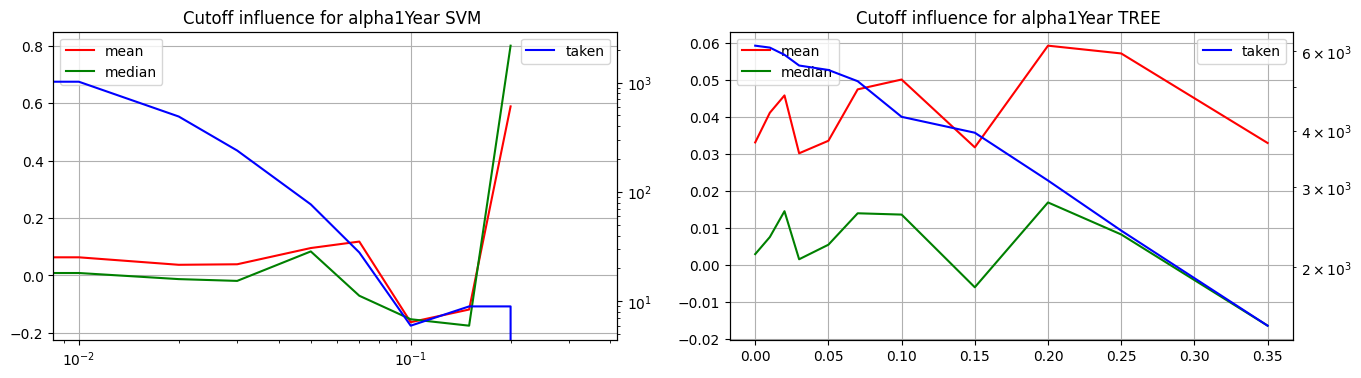

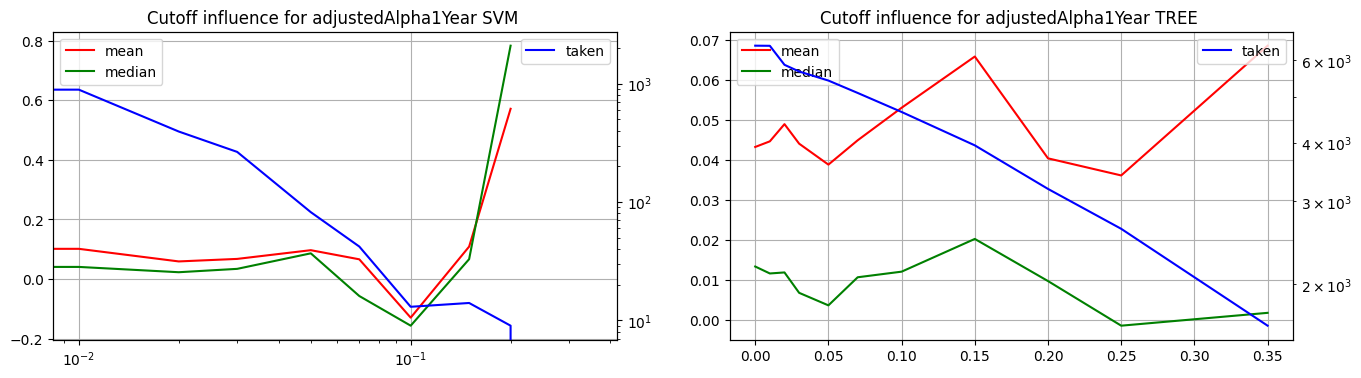

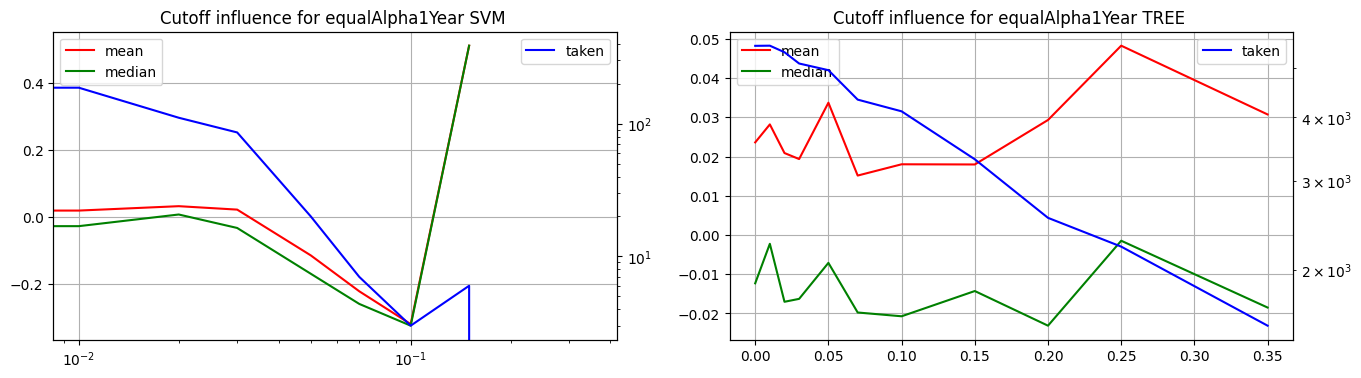

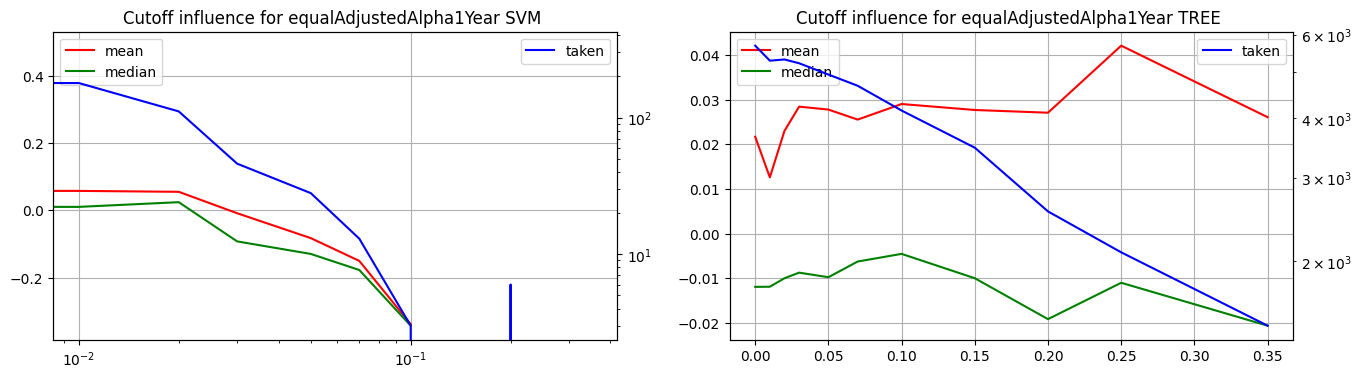

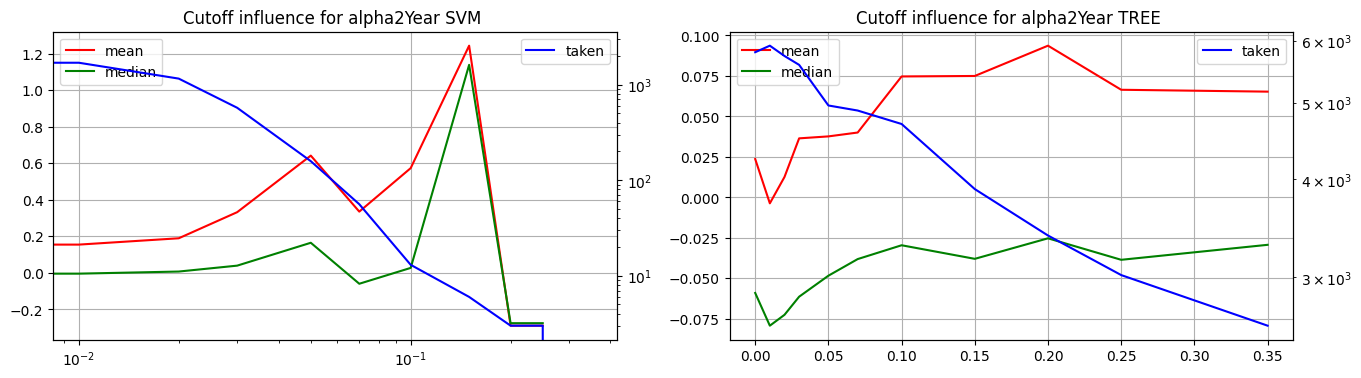

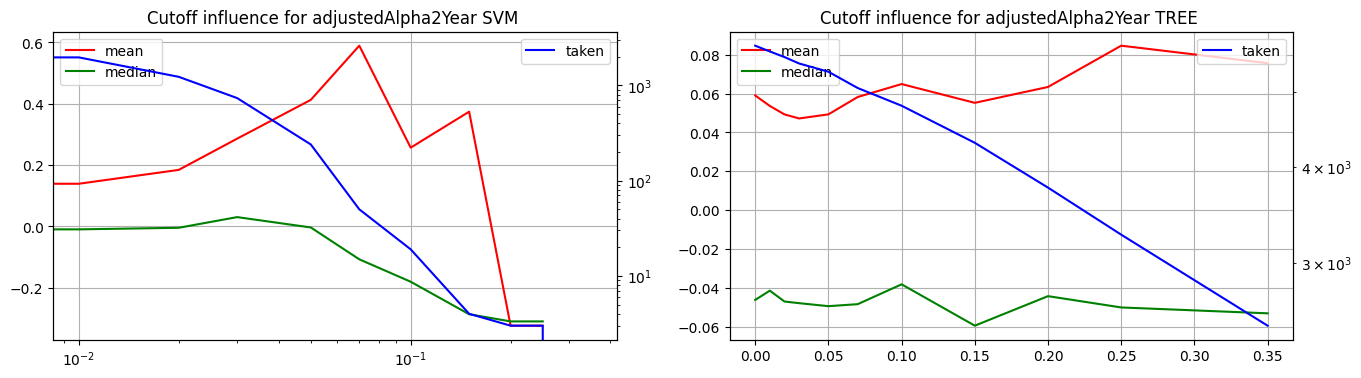

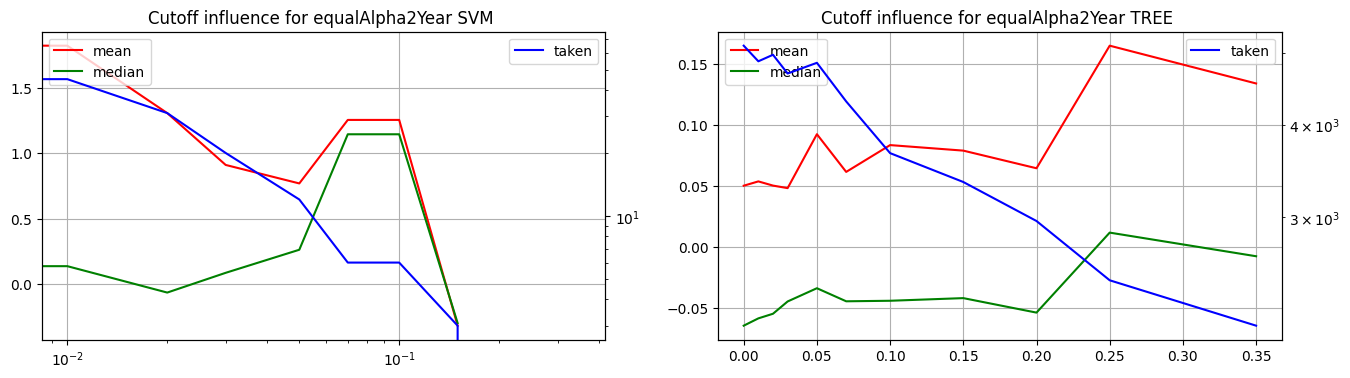

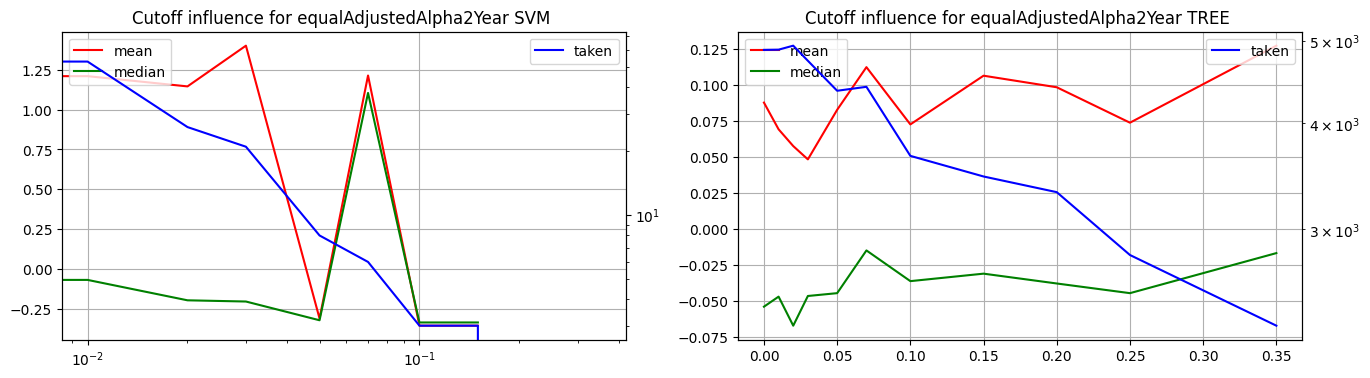

In [6]:
x = cutoffs
for yLabel in resultsToPlot.keys():
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 4))
    drawFrom1results(ax1, ax2, resultsToPlot, yLabel)
    plt.show()